Debugging neural networks is a challenging task. It often requires a profound understanding of the techniques involved.

It is therefore important to have a well-defined strategy and follow some guidelines that will simplify model debugging. In general, it is crucial to implement the model step-by-step and do several checks along the way. The worse thing you can do is implement a complex system in one shot and hope everything is working.

Here are some additional suggestions:
1. Before implementing your model, carefully check your data. Make sure, for instance, that the inputs and the labels match. If you shuffle the data, make sure to shuffle inputs and labels consistently (to avoid input-label mismatches).

2. Start with a simple model (e.g., a linear model). Remember: "*the more powerful the model the more sophisticated the bugs*". Make sure the code is running. Make sure the model is in train modality during training and eval modality during validation and test. The model will likely underfit, but you should see at least some small improvements in the training loss. If this does not happen:
- Carefully check the batches and ensure there is a matching between inputs and labels.
- Check the shapes on the tensors involved in your model and make sure they correspond to your expectations.
- Check the parameters of the network. If they remain constant, your gradient is likely zero. This can be caused by forgetting to call the backpropagation method or the step method of the optimizer.
- Make sure you applied the softmax on the right axis.
- Tweek a bit the hyperparameters of the model to see if there is at least one configuration that allows the loss to decrease a bit.
3. Implement your final model. Initialize it and make sure it runs. Fix possible dimensionality mismatch issues. Make sure all the shapes are the ones you expect.
4. Do an **overfitting test**. If your model cannot overfit on a tiny dataset (e.g., take 5-10 examples only) it likely contains a bug somewhere. To do an overfitting test, feed the model with a single batch composed of 5-10 examples. Run the model for several epochs with a pretty high learning rate. If everything is correct, you should see an almost perfect training loss and a very high validation loss. This means that the model can memorize data. Data memorization is not what we want in the end, but models that cannot overfit likely have a bug to fix.
5. Now, you can run your experiment. Check if the loss is decreasing. If you observe numerical instabilities (e.g., NaN) try to reduce the learning rate. If that does not help, consider using gradient clipping. You have to do your best to tune the hyperparameters of the model to maximize the validation performance.

Many other things can go wrong. You will progressively gain more and more experience and this will help you with debugging.

## Exercise 1 - Debugging a PyTorch Code

Let's now do a debug exercise with PyTorch.



Let's import the needed libraries:

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

torch.manual_seed(1)

We want to implement a digit classification with the MNIST dataset using the following MLP:

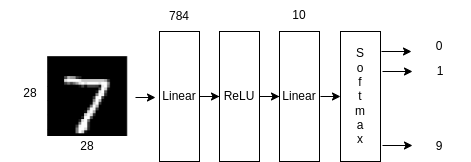

**Run the following code** that attempts to implement the aforementioned model.

In [ ]:
# Neural Network Module
class Net(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(Net,self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(hidden_size, num_classes)

  def forward(self,x):
    out = self.fc1(x)
    out = self.relu(out)
    out = self.fc2(out)
    return out

# Hyperparameters
batch_size=128
epochs=20
lr=0.005
input_size = 784
hidden_size = 500
num_classes = 10

# Model initalization
model = Net(input_size, hidden_size, num_classes).to('cuda:0')
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Datasets
train_data = datasets.MNIST(root = './data', train = True,
                        transform = transforms.ToTensor(), download = True)

test_data = datasets.MNIST(root = './data', train = False,
                       transform = transforms.ToTensor())
# Data loaders
train_loader = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = batch_size,
                                             shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_data,
                                      batch_size = batch_size,
                                      shuffle = False)

# Training over all batches
def train(train_loader, model, loss, optimizer):
  losses=[]
  model.train()
  for images,labels in train_loader:
    outputs = model(images)
    l = loss(outputs, labels)
    l.backward()
    optimizer.step()
    losses.append(l)
  return torch.tensor(losses).mean()

# Test over all batches
def test(test_loader, model, loss):
  losses=[]
  err=0
  model.eval()
  for images,labels in test_loader:
    outputs = model(images)
    l = loss(outputs, labels)
    losses.append(l)

    predictions = torch.argmax(F.softmax(outputs, dim=1), dim=1)
    err = err + (predictions!=labels).sum()
  return torch.tensor(losses).mean(), err/len(test_loader.dataset)

# Training loop
train_losses=[]
test_losses=[]
for epoch in range(epochs):
  train_loss = train(train_loader, model, loss, optimizer)
  test_loss, test_err = test(test_loader, model, loss)
  train_losses.append(train_loss)
  test_losses.append(test_loss)

  print('Epoch: {}  train_loss={:.4f}, test_loss={:.4f}, test_err={:.2f}%'.format(epoch+1, train_loss, test_loss, test_err*100))

plt.plot(train_losses, '-s', label='train')
plt.plot(test_losses, '-s', label='test')
plt.ylabel('Loss')
plt.ylabel('Epochs')
plt.legend()
plt.show()

The code has several bugs in this code.

**Modify the code above** to fix all these bugs. Do the minimum amount of modifications needed to make the model work. Do not rewrite everything from scratch.

Epoch: 1  train_loss=0.2134, test_loss=0.1026, test_err=3.30%
Epoch: 2  train_loss=0.0884, test_loss=0.0827, test_err=2.65%
Epoch: 3  train_loss=0.0619, test_loss=0.1057, test_err=2.96%
Epoch: 4  train_loss=0.0458, test_loss=0.1013, test_err=2.65%
Epoch: 5  train_loss=0.0393, test_loss=0.0956, test_err=2.49%
Epoch: 6  train_loss=0.0374, test_loss=0.1042, test_err=2.49%
Epoch: 7  train_loss=0.0334, test_loss=0.1049, test_err=2.15%
Epoch: 8  train_loss=0.0303, test_loss=0.1127, test_err=2.29%
Epoch: 9  train_loss=0.0230, test_loss=0.1147, test_err=2.23%
Epoch: 10  train_loss=0.0247, test_loss=0.1361, test_err=2.51%
Epoch: 11  train_loss=0.0234, test_loss=0.1213, test_err=2.49%
Epoch: 12  train_loss=0.0222, test_loss=0.1419, test_err=2.57%
Epoch: 13  train_loss=0.0214, test_loss=0.1247, test_err=2.10%
Epoch: 14  train_loss=0.0238, test_loss=0.1486, test_err=2.27%
Epoch: 15  train_loss=0.0186, test_loss=0.1536, test_err=2.34%
Epoch: 16  train_loss=0.0212, test_loss=0.1604, test_err=2.44%
E

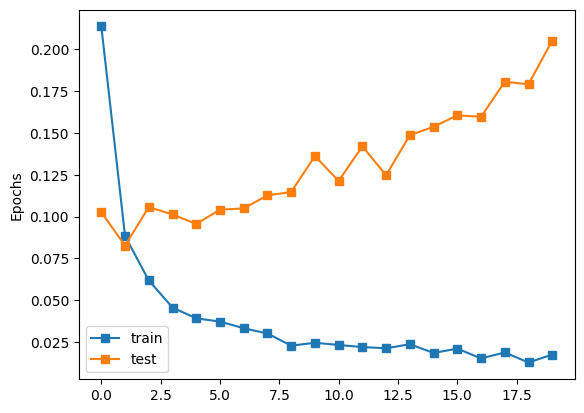

In [ ]:
# Your code here
# Neural Network Module
class Net(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(Net,self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(hidden_size, num_classes)

  def forward(self,x):
    x = x.view(x.size(0), -1)
    out = self.fc1(x)
    out = self.relu(out)
    out = self.fc2(out)
    return out

# Hyperparameters
batch_size=128
epochs=20
lr=0.005
input_size = 784
hidden_size = 500
num_classes = 10

# Model initalization
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = Net(input_size, hidden_size, num_classes).to(device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Datasets
train_data = datasets.MNIST(root = './data', train = True,
                        transform = transforms.ToTensor(), download = True)

test_data = datasets.MNIST(root = './data', train = False,
                       transform = transforms.ToTensor())
# Data loaders
train_loader = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = batch_size,
                                             shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_data,
                                      batch_size = batch_size,
                                      shuffle = False)

# Training over all batches
def train(train_loader, model, loss, optimizer):
  losses=[]
  model.train()
  for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        l = loss(outputs, labels)
        l.backward()
        optimizer.step()
        losses.append(l)
  return torch.stack(losses).mean()

# Test over all batches
def test(test_loader, model, loss):
    losses = []
    err = 0
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            l = loss(outputs, labels)
            losses.append(l)

            predictions = torch.argmax(outputs, dim=1)
            err += (predictions != labels).sum().item()
    return torch.tensor(losses).mean(), err / len(test_loader.dataset)

# Training loop
train_losses=[]
test_losses=[]
for epoch in range(epochs):
  train_loss = train(train_loader, model, loss, optimizer)
  test_loss, test_err = test(test_loader, model, loss)
  train_losses.append(train_loss.item())
  test_losses.append(test_loss.item())

  print('Epoch: {}  train_loss={:.4f}, test_loss={:.4f}, test_err={:.2f}%'.format(epoch+1, train_loss, test_loss, test_err*100))

plt.plot(train_losses, '-s', label='train')
plt.plot(test_losses, '-s', label='test')
plt.ylabel('Loss')
plt.ylabel('Epochs')
plt.legend()
plt.show()

If everything is fine, you should obtain something like this:

```
Epoch: 1  train_loss=0.2042, test_loss=0.0968, test_err=3.11%
Epoch: 2  train_loss=0.0876, test_loss=0.0816, test_err=2.64%
Epoch: 3  train_loss=0.0589, test_loss=0.0827, test_err=2.42%
Epoch: 4  train_loss=0.0464, test_loss=0.1234, test_err=3.35%
Epoch: 5  train_loss=0.0413, test_loss=0.0950, test_err=2.49%
Epoch: 6  train_loss=0.0370, test_loss=0.0904, test_err=2.29%
Epoch: 7  train_loss=0.0282, test_loss=0.1006, test_err=2.24%
Epoch: 8  train_loss=0.0286, test_loss=0.1177, test_err=2.49%
Epoch: 9  train_loss=0.0269, test_loss=0.1185, test_err=2.20%
Epoch: 10  train_loss=0.0244, test_loss=0.1198, test_err=2.16%
Epoch: 11  train_loss=0.0248, test_loss=0.1093, test_err=1.97%
Epoch: 12  train_loss=0.0202, test_loss=0.1360, test_err=2.19%
Epoch: 13  train_loss=0.0249, test_loss=0.1241, test_err=2.07%
Epoch: 14  train_loss=0.0210, test_loss=0.1535, test_err=2.36%
Epoch: 15  train_loss=0.0227, test_loss=0.1486, test_err=2.28%
Epoch: 16  train_loss=0.0181, test_loss=0.1562, test_err=2.27%
Epoch: 17  train_loss=0.0190, test_loss=0.1517, test_err=2.13%
Epoch: 18  train_loss=0.0203, test_loss=0.1653, test_err=2.12%
Epoch: 19  train_loss=0.0185, test_loss=0.1533, test_err=2.10%
Epoch: 20  train_loss=0.0167, test_loss=0.1902, test_err=2.23%
```



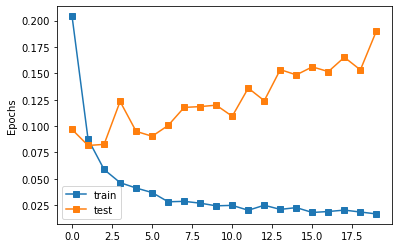

The classification error should be around 2% (98% Accuracy).

**Fill up the following table** with the bugs you found. Describe briefly how did you fix them.


| Bug   |      How I fix it
|----------|:-------------:|
| device definition |  Added line with device initialization to ensure that the machine supports GPU, or can switch to cpu, if no GPU. Also made sure with images, labels|
| Dimensions mismatch in fc1 |  Flattened the input tensor before passing to fc layers|
| optimizer.zero_grad() |  Added this line before the backward pass in the training loop and before proceeding to test loop|
| .item() |  Added while extracting float values from pytorch tensor for both train and test losses since it was run on cpu|


## Exercise 2 - Model Improvements

The simple model of the previous exercise already has a good performance.
However, we can do it better on MNIST. For instance, you might have noticed that the model (even a small model like the one we used) tends to overfit quite quickly. In the following, we will progressively improve the model.

## Exercise 2.1 - Adding Batch Normalization
A regularization technique that normally helps is called [batch normalization](https://en.wikipedia.org/wiki/Batch_normalization). It essentially normalizes the mean and the variance of the hidden activations over the batch axis.

**Modify the code above** to add batch normalization. Use [torch.nn.BatchNorm1d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html) and apply it right after the first linear transformation.





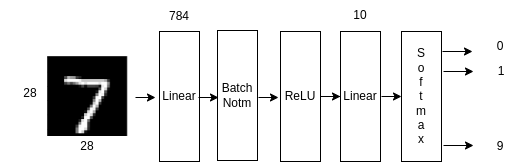

Epoch: 1  train_loss=0.1838, test_loss=0.1136, test_err=3.62%
Epoch: 2  train_loss=0.0819, test_loss=0.0863, test_err=2.63%
Epoch: 3  train_loss=0.0500, test_loss=0.0829, test_err=2.59%
Epoch: 4  train_loss=0.0388, test_loss=0.0673, test_err=2.17%
Epoch: 5  train_loss=0.0319, test_loss=0.0788, test_err=2.19%
Epoch: 6  train_loss=0.0223, test_loss=0.0865, test_err=2.46%
Epoch: 7  train_loss=0.0221, test_loss=0.0762, test_err=2.15%
Epoch: 8  train_loss=0.0177, test_loss=0.0694, test_err=1.81%
Epoch: 9  train_loss=0.0180, test_loss=0.0763, test_err=2.02%
Epoch: 10  train_loss=0.0160, test_loss=0.0806, test_err=2.11%
Epoch: 11  train_loss=0.0136, test_loss=0.0725, test_err=1.93%
Epoch: 12  train_loss=0.0139, test_loss=0.0939, test_err=2.00%
Epoch: 13  train_loss=0.0117, test_loss=0.0956, test_err=2.27%
Epoch: 14  train_loss=0.0111, test_loss=0.0780, test_err=1.94%
Epoch: 15  train_loss=0.0117, test_loss=0.0992, test_err=2.03%
Epoch: 16  train_loss=0.0093, test_loss=0.0951, test_err=1.97%
E

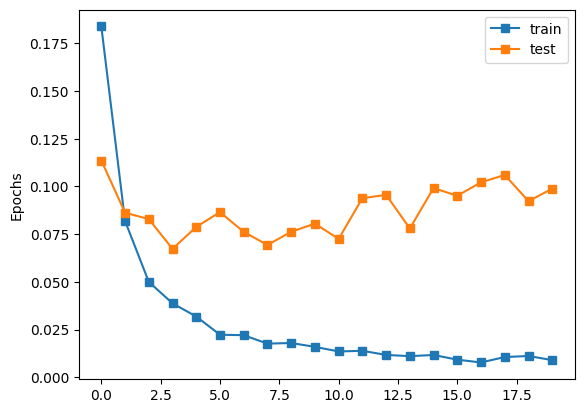

In [ ]:
# Your code here
# Neural Network Module
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)  # Batch Normalization layer
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        out = self.fc1(x)
        out = self.bn1(out)  # Applying Batch Normalization
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Hyperparameters
batch_size=128
epochs=20
lr=0.005
input_size = 784
hidden_size = 500
num_classes = 10

# Model initalization
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = Net(input_size, hidden_size, num_classes).to(device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Datasets
train_data = datasets.MNIST(root = './data', train = True,
                        transform = transforms.ToTensor(), download = True)

test_data = datasets.MNIST(root = './data', train = False,
                       transform = transforms.ToTensor())
# Data loaders
train_loader = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = batch_size,
                                             shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_data,
                                      batch_size = batch_size,
                                      shuffle = False)

# Training over all batches
def train(train_loader, model, loss, optimizer):
  losses=[]
  model.train()
  for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        l = loss(outputs, labels)
        l.backward()
        optimizer.step()
        losses.append(l)
  return torch.stack(losses).mean()

# Test over all batches
def test(test_loader, model, loss):
    losses = []
    err = 0
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            l = loss(outputs, labels)
            losses.append(l)

            predictions = torch.argmax(outputs, dim=1)
            err += (predictions != labels).sum().item()
    return torch.tensor(losses).mean(), err / len(test_loader.dataset)

# Training loop
train_losses=[]
test_losses=[]
for epoch in range(epochs):
  train_loss = train(train_loader, model, loss, optimizer)
  test_loss, test_err = test(test_loader, model, loss)
  train_losses.append(train_loss.item())
  test_losses.append(test_loss.item())

  print('Epoch: {}  train_loss={:.4f}, test_loss={:.4f}, test_err={:.2f}%'.format(epoch+1, train_loss, test_loss, test_err*100))

plt.plot(train_losses, '-s', label='train')
plt.plot(test_losses, '-s', label='test')
plt.ylabel('Loss')
plt.ylabel('Epochs')
plt.legend()
plt.show()

If everything goes well, you should get something like this:


```
Epoch: 1  train_loss=0.1814, test_loss=0.1229, test_err=4.09%
Epoch: 2  train_loss=0.0816, test_loss=0.0670, test_err=2.19%
Epoch: 3  train_loss=0.0523, test_loss=0.0782, test_err=2.42%
Epoch: 4  train_loss=0.0386, test_loss=0.0739, test_err=2.33%
Epoch: 5  train_loss=0.0296, test_loss=0.0731, test_err=2.04%
Epoch: 6  train_loss=0.0251, test_loss=0.0828, test_err=2.12%
Epoch: 7  train_loss=0.0220, test_loss=0.0751, test_err=1.99%
Epoch: 8  train_loss=0.0181, test_loss=0.0988, test_err=2.34%
Epoch: 9  train_loss=0.0168, test_loss=0.0771, test_err=1.90%
Epoch: 10  train_loss=0.0149, test_loss=0.0781, test_err=1.99%
Epoch: 11  train_loss=0.0153, test_loss=0.0930, test_err=2.47%
Epoch: 12  train_loss=0.0122, test_loss=0.1029, test_err=2.31%
Epoch: 13  train_loss=0.0146, test_loss=0.1006, test_err=2.27%
Epoch: 14  train_loss=0.0110, test_loss=0.0922, test_err=2.02%
Epoch: 15  train_loss=0.0117, test_loss=0.0860, test_err=2.04%
Epoch: 16  train_loss=0.0092, test_loss=0.0818, test_err=1.84%
Epoch: 17  train_loss=0.0079, test_loss=0.0933, test_err=1.98%
Epoch: 18  train_loss=0.0075, test_loss=0.0840, test_err=1.87%
Epoch: 19  train_loss=0.0102, test_loss=0.1054, test_err=2.16%
Epoch: 20  train_loss=0.0096, test_loss=0.0950, test_err=1.89%
```



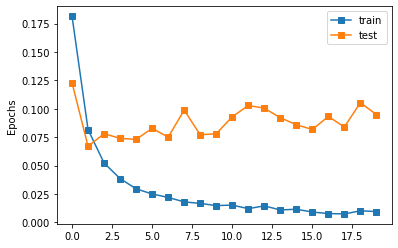

The best test error is about 1.90%.
As you can see, there is a little improvement in the performance when adding batch normalization.

## Exercise 2.2 - Adding Dropout

Another popular regularization technique is [dropout](https://towardsdatascience.com/dropout-in-neural-networks-47a162d621d9). It randomly drops neurons to prevent coadaptation.

**Modify the code above** to introduce dropout. Use [torch.nn.Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) and apply it right after the ReLU activations. Use a dropout factor of 0.5.

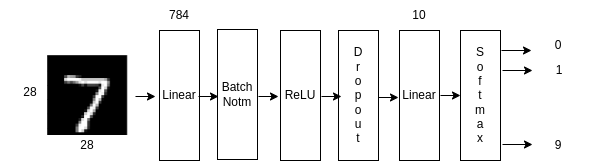

Epoch: 1  train_loss=0.2477, test_loss=0.1123, test_err=3.33%
Epoch: 2  train_loss=0.1356, test_loss=0.0858, test_err=2.70%
Epoch: 3  train_loss=0.1092, test_loss=0.0786, test_err=2.51%
Epoch: 4  train_loss=0.0926, test_loss=0.0664, test_err=1.99%
Epoch: 5  train_loss=0.0815, test_loss=0.0652, test_err=1.97%
Epoch: 6  train_loss=0.0736, test_loss=0.0660, test_err=2.03%
Epoch: 7  train_loss=0.0649, test_loss=0.0630, test_err=1.90%
Epoch: 8  train_loss=0.0635, test_loss=0.0625, test_err=1.83%
Epoch: 9  train_loss=0.0555, test_loss=0.0622, test_err=1.89%
Epoch: 10  train_loss=0.0573, test_loss=0.0582, test_err=1.73%
Epoch: 11  train_loss=0.0502, test_loss=0.0612, test_err=1.76%
Epoch: 12  train_loss=0.0496, test_loss=0.0590, test_err=1.62%
Epoch: 13  train_loss=0.0449, test_loss=0.0615, test_err=1.69%
Epoch: 14  train_loss=0.0436, test_loss=0.0576, test_err=1.67%
Epoch: 15  train_loss=0.0429, test_loss=0.0608, test_err=1.59%
Epoch: 16  train_loss=0.0409, test_loss=0.0678, test_err=1.71%
E

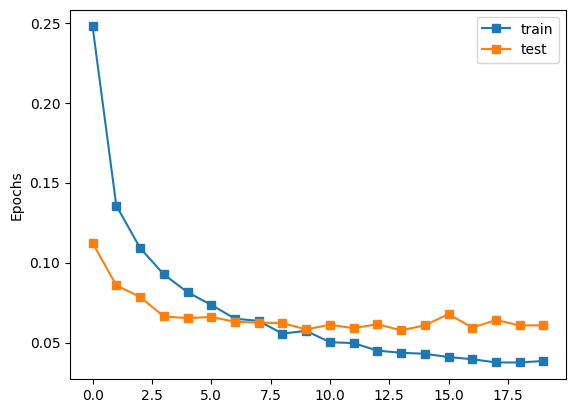

In [ ]:
# Your code here
# Neural Network Module
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout_rate=0.5):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_rate)  # Dropout layer
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)  # Applying Dropout after ReLU
        out = self.fc2(out)
        return out

# Hyperparameters
batch_size=128
epochs=20
lr=0.005
input_size = 784
hidden_size = 500
num_classes = 10

# Model initalization
dropout_rate = 0.5
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = Net(input_size, hidden_size, num_classes, dropout_rate).to(device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Datasets
train_data = datasets.MNIST(root = './data', train = True,
                        transform = transforms.ToTensor(), download = True)

test_data = datasets.MNIST(root = './data', train = False,
                       transform = transforms.ToTensor())
# Data loaders
train_loader = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = batch_size,
                                             shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_data,
                                      batch_size = batch_size,
                                      shuffle = False)

# Training over all batches
def train(train_loader, model, loss, optimizer):
  losses=[]
  model.train()
  for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        l = loss(outputs, labels)
        l.backward()
        optimizer.step()
        losses.append(l)
  return torch.stack(losses).mean()

# Test over all batches
def test(test_loader, model, loss):
    losses = []
    err = 0
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            l = loss(outputs, labels)
            losses.append(l)

            predictions = torch.argmax(outputs, dim=1)
            err += (predictions != labels).sum().item()
    return torch.tensor(losses).mean(), err / len(test_loader.dataset)

# Training loop
train_losses=[]
test_losses=[]
for epoch in range(epochs):
  train_loss = train(train_loader, model, loss, optimizer)
  test_loss, test_err = test(test_loader, model, loss)
  train_losses.append(train_loss.item())
  test_losses.append(test_loss.item())

  print('Epoch: {}  train_loss={:.4f}, test_loss={:.4f}, test_err={:.2f}%'.format(epoch+1, train_loss, test_loss, test_err*100))

plt.plot(train_losses, '-s', label='train')
plt.plot(test_losses, '-s', label='test')
plt.ylabel('Loss')
plt.ylabel('Epochs')
plt.legend()
plt.show()

If everything works well, you should see the following output:



```
Epoch: 1  train_loss=0.2432, test_loss=0.1191, test_err=3.82%
Epoch: 2  train_loss=0.1398, test_loss=0.0780, test_err=2.52%
Epoch: 3  train_loss=0.1083, test_loss=0.0789, test_err=2.49%
Epoch: 4  train_loss=0.0933, test_loss=0.0722, test_err=2.37%
Epoch: 5  train_loss=0.0834, test_loss=0.0639, test_err=2.07%
Epoch: 6  train_loss=0.0730, test_loss=0.0657, test_err=2.07%
Epoch: 7  train_loss=0.0671, test_loss=0.0618, test_err=1.82%
Epoch: 8  train_loss=0.0635, test_loss=0.0642, test_err=2.05%
Epoch: 9  train_loss=0.0580, test_loss=0.0572, test_err=1.77%
Epoch: 10  train_loss=0.0563, test_loss=0.0593, test_err=1.79%
Epoch: 11  train_loss=0.0517, test_loss=0.0604, test_err=1.87%
Epoch: 12  train_loss=0.0485, test_loss=0.0568, test_err=1.77%
Epoch: 13  train_loss=0.0456, test_loss=0.0621, test_err=1.75%
Epoch: 14  train_loss=0.0488, test_loss=0.0536, test_err=1.63%
Epoch: 15  train_loss=0.0437, test_loss=0.0572, test_err=1.73%
Epoch: 16  train_loss=0.0406, test_loss=0.0593, test_err=1.59%
Epoch: 17  train_loss=0.0409, test_loss=0.0571, test_err=1.71%
Epoch: 18  train_loss=0.0410, test_loss=0.0564, test_err=1.53%
Epoch: 19  train_loss=0.0367, test_loss=0.0626, test_err=1.70%
Epoch: 20  train_loss=0.0371, test_loss=0.0608, test_err=1.51%
```



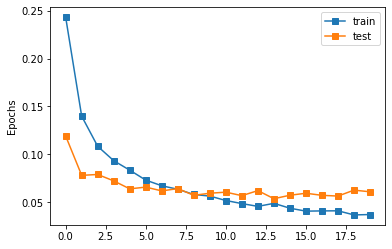

Dropout further improves the performance. Now, the best test error should be around 1.5%.

## Exercise 2.3 - Add a Convolutional FrontEnd

Let's now add to the model above a convolutional block before the fully-connected one.
The convolutional block should contain the following sequence of operations (in the specified order):
1. 2D convolution with 20 channels and a kernel size of (5,5). Use [torch.nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html).
2. 2D Batch normalization (use [torch.nn.BatchNorm2d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)).
3. 2D Max pooling with a pool size of 2 (use [MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html)).
4. ReLU activation function.

Hint: compute the new input dimensionality of the first linear layer in the initialization method (avoid hard-coding it). Check the documentation of the conv2d and maxpoll2d methods to estimate it. In the forward method, you can use torch.flatten() or .reshape() to get the expected tensor dimensionality in input to the first linear layer.

Epoch: 1  train_loss=0.1335, test_loss=0.0733, test_err=2.35%
Epoch: 2  train_loss=0.0626, test_loss=0.0425, test_err=1.42%
Epoch: 3  train_loss=0.0459, test_loss=0.0415, test_err=1.25%
Epoch: 4  train_loss=0.0362, test_loss=0.0352, test_err=1.13%
Epoch: 5  train_loss=0.0314, test_loss=0.0332, test_err=0.98%
Epoch: 6  train_loss=0.0277, test_loss=0.0422, test_err=1.24%
Epoch: 7  train_loss=0.0244, test_loss=0.0384, test_err=0.98%
Epoch: 8  train_loss=0.0192, test_loss=0.0378, test_err=1.05%
Epoch: 9  train_loss=0.0212, test_loss=0.0428, test_err=1.17%
Epoch: 10  train_loss=0.0207, test_loss=0.0410, test_err=1.09%
Epoch: 11  train_loss=0.0169, test_loss=0.0391, test_err=1.11%
Epoch: 12  train_loss=0.0175, test_loss=0.0420, test_err=1.02%
Epoch: 13  train_loss=0.0175, test_loss=0.0548, test_err=1.34%
Epoch: 14  train_loss=0.0146, test_loss=0.0428, test_err=1.19%
Epoch: 15  train_loss=0.0139, test_loss=0.0377, test_err=0.96%
Epoch: 16  train_loss=0.0137, test_loss=0.0384, test_err=0.93%
E

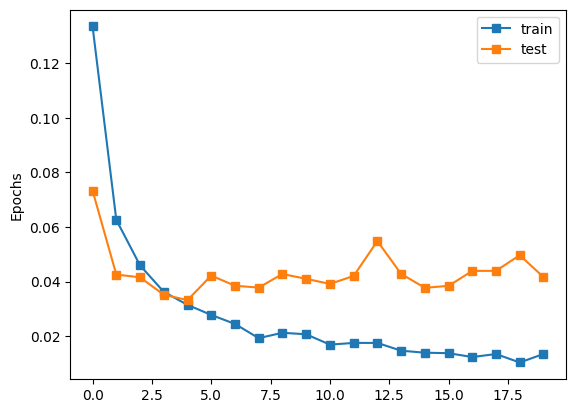

In [ ]:
# Your code here
# Neural Network Module
class Net(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super(Net, self).__init__()
        # Convolutional FrontEnd
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 20, kernel_size=5),
            nn.BatchNorm2d(20),
            nn.MaxPool2d(2),
            nn.ReLU()
        )

        conv_output_size = self._get_conv_output_size((1, 28, 28))
        self.fc1 = nn.Linear(conv_output_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def _get_conv_output_size(self, shape):
        with torch.no_grad():
            dummy_tensor = torch.zeros(1, *shape)
            conv_output = self.conv_block(dummy_tensor)
            return int(conv_output.view(1, -1).size(1))

    def forward(self, x):
        out = self.conv_block(x)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

# Hyperparameters
batch_size=128
epochs=20
lr=0.005
input_size = 784
hidden_size = 500
num_classes = 10

# Model initalization
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = Net(num_classes).to(device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Datasets
train_data = datasets.MNIST(root = './data', train = True,
                        transform = transforms.ToTensor(), download = True)

test_data = datasets.MNIST(root = './data', train = False,
                       transform = transforms.ToTensor())
# Data loaders
train_loader = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = batch_size,
                                             shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_data,
                                      batch_size = batch_size,
                                      shuffle = False)

# Training over all batches
def train(train_loader, model, loss, optimizer):
  losses=[]
  model.train()
  for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        l = loss(outputs, labels)
        l.backward()
        optimizer.step()
        losses.append(l)
  return torch.stack(losses).mean()

# Test over all batches
def test(test_loader, model, loss):
    losses = []
    err = 0
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            l = loss(outputs, labels)
            losses.append(l)

            predictions = torch.argmax(outputs, dim=1)
            err += (predictions != labels).sum().item()
    return torch.tensor(losses).mean(), err / len(test_loader.dataset)

# Training loop
train_losses=[]
test_losses=[]
for epoch in range(epochs):
  train_loss = train(train_loader, model, loss, optimizer)
  test_loss, test_err = test(test_loader, model, loss)
  train_losses.append(train_loss.item())
  test_losses.append(test_loss.item())

  print('Epoch: {}  train_loss={:.4f}, test_loss={:.4f}, test_err={:.2f}%'.format(epoch+1, train_loss, test_loss, test_err*100))

plt.plot(train_losses, '-s', label='train')
plt.plot(test_losses, '-s', label='test')
plt.ylabel('Loss')
plt.ylabel('Epochs')
plt.legend()
plt.show()

If everything is correct, you should see something like this:


```
Epoch: 1  train_loss=0.1512, test_loss=0.0464, test_err=1.46%
Epoch: 2  train_loss=0.0684, test_loss=0.0473, test_err=1.70%
Epoch: 3  train_loss=0.0509, test_loss=0.0349, test_err=1.14%
Epoch: 4  train_loss=0.0450, test_loss=0.0303, test_err=0.91%
Epoch: 5  train_loss=0.0387, test_loss=0.0413, test_err=1.15%
Epoch: 6  train_loss=0.0393, test_loss=0.0407, test_err=1.15%
Epoch: 7  train_loss=0.0328, test_loss=0.0375, test_err=1.02%
Epoch: 8  train_loss=0.0290, test_loss=0.0468, test_err=1.28%
Epoch: 9  train_loss=0.0310, test_loss=0.0394, test_err=1.12%
Epoch: 10  train_loss=0.0304, test_loss=0.0374, test_err=1.05%
Epoch: 11  train_loss=0.0313, test_loss=0.0437, test_err=1.09%
Epoch: 12  train_loss=0.0268, test_loss=0.0548, test_err=1.35%
Epoch: 13  train_loss=0.0293, test_loss=0.0536, test_err=1.20%
Epoch: 14  train_loss=0.0265, test_loss=0.0472, test_err=1.14%
Epoch: 15  train_loss=0.0234, test_loss=0.0479, test_err=1.05%
Epoch: 16  train_loss=0.0215, test_loss=0.0422, test_err=0.88%
Epoch: 17  train_loss=0.0211, test_loss=0.0419, test_err=0.94%
Epoch: 18  train_loss=0.0218, test_loss=0.0473, test_err=1.00%
Epoch: 19  train_loss=0.0205, test_loss=0.0485, test_err=0.96%
Epoch: 20  train_loss=0.0215, test_loss=0.0503, test_err=0.90%

```



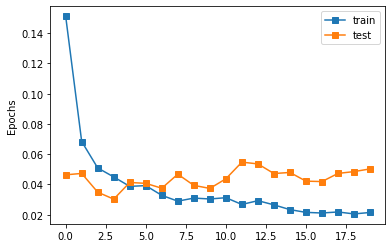

The convolutional front-end helps improve performance significantly. Now, the best performance on the test set should be between 0.8%-0.9%.

**Note**: in this tutorial, we use relatively simple models. When models get more complex (e.g, you have more layers and types of neural networks involved) you can split your models into submodels and then combine them. You can also use a sequential container ([torch.nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) to combine pipelines of computations (without the need to write the forward method yourself).